In [5]:
from dolfin import * 
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
import logging 
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)

import dolfin 
vers = dolfin.__version__
verss = vers.split('.')
if int(verss[1]) > 0:
    parameters.reorder_dofs_serial = False

In [6]:
def generate_matrices_2d(N):
	mesh = UnitSquareMesh(N, N)
	mesh.coordinates()[:,0] = mesh.coordinates()[:,0]*2.0-1.0
	mesh.coordinates()[:,1] = mesh.coordinates()[:,1]*2.0-1.0

	def boundary(x):
		return x[0] < -1 + DOLFIN_EPS or x[1]< -1 +  DOLFIN_EPS or x[0]>1 - DOLFIN_EPS  or x[1]>1 - DOLFIN_EPS

	V = FunctionSpace(mesh, "CG", 1)
	bcs = [DirichletBC(V,Constant(0.0), boundary)]
	# Define variational problem
	u = TrialFunction(V)
	v = TestFunction(V)
	f = Expression('  ((pow(x[0],2) <= 0.25 ) & (pow(x[1],2) <= 0.25))? 1 : 0')
	a = inner(grad(u), grad(v))*dx
	L = f*v*dx 
	# Assemble system
	A,b = assemble_system(a,L,bcs)
	A_mat = as_backend_type(A).mat(); 
	from scipy.sparse import csr_matrix
	As = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)


	return As.toarray(),b.array()

def visualize_solution_2d(x):
	import matplotlib
	fig = plt.figure()
	ax = fig.gca(projection='3d')
	xx = np.linspace(-1,1,N+1)
	XX,YY = np.meshgrid(xx,xx)
         
	R = np.reshape(x, (N+1,N+1))
	surf = ax.plot_surface(XX, YY, R, rstride=4, cstride=4, color='b')
	plt.show()

def pcg_example(): 
	m = 1000;
	d = np.zeros((m,1))
	for i in np.arange(m):
	    d[i] = 0.2 + np.sqrt(i);

	A = np.diag(np.ones((m-1,)),1) + np.diag(np.ones((m-1,)),-1) + np.diag(d[:,0]) + np.diag(np.ones((m-100,)),100) + np.diag(np.ones((m-100,)),-100)
	b = np.ones((m,))
	return A,b


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


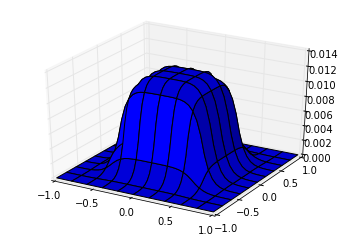

In [7]:
N = 40

#Section 2.2

A, b = generate_matrices_2d(N)
[m,n] = np.shape(A)
x_jacobi = np.zeros(np.shape(b));
maxit = 20; 
nm = np.zeros((maxit,1))

D = np.diag(np.diag(A))
R = A - D
Dinvb = np.linalg.solve(D,b)
for k in np.arange(maxit):
	x_jacobi = Dinvb - np.linalg.solve(D,np.dot(R,x_jacobi) )
	nm[k] = np.linalg.norm(np.dot(A,x_jacobi)-b)
visualize_solution_2d(x_jacobi)


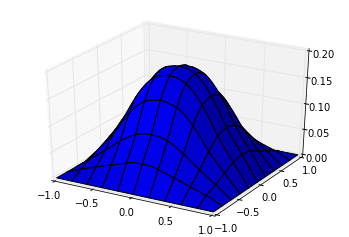

In [8]:
x_cg = np.zeros(np.shape(b));
rk = b-np.dot(A,x_cg)
p = rk
for k in np.arange(maxit):
	alpha = np.dot(rk,rk)/np.dot(p,np.dot(A,p))
	x_cg = x_cg + alpha*p
	nm[k] = np.linalg.norm(np.dot(A,x_cg)-b)
	rkp1 = rk - alpha*np.dot(A,p)
	beta = np.dot(rkp1,rkp1)/np.dot(rk,rk)
	p = rkp1 + beta*p
	rk = rkp1
visualize_solution_2d(x_cg)

In [9]:
[A,b] = pcg_example()
maxit = 100
tol = 1e-6
nm = np.zeros((maxit,1))

x_cg = np.zeros(np.shape(b));
rk = b-np.dot(A,x_cg)
p = rk
for k in np.arange(maxit):
	alpha = np.dot(rk,rk)/np.dot(p,np.dot(A,p))
	x_cg = x_cg + alpha*p
	rkp1 = rk - alpha*np.dot(A,p)
	nm[k] = np.linalg.norm(np.dot(A,x_cg)-b)
	if (nm[k] < tol): 
		print k
		break 
	beta = np.dot(rkp1,rkp1)/np.dot(rk,rk)
	p = rkp1 + beta*p
	rk = rkp1

x_pcg = np.zeros(np.shape(b));
D = np.diag(np.diag(A))
rk = b-np.dot(A,x_pcg)
zk = np.linalg.solve(D,rk)
p = zk
for k in np.arange(maxit):
	alpha = np.dot(rk,zk)/np.dot(p,np.dot(A,p))
	x_pcg = x_pcg + alpha*p
	nm[k] = np.linalg.norm(np.dot(A,x_pcg)-b)
	if (nm[k] < tol): 
		print k
		break 
	rkp1 = rk - alpha*np.dot(A,p)
	zkp1 = np.linalg.solve(D,rkp1)
	beta = np.dot(zkp1,rkp1)/np.dot(zk,rk)
	p = zkp1 + beta*p
	rk = rkp1
	zk = zkp1

56
19
